# Football Object Detection with Tactical Map Position Estimation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.5/756.5 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# Import libraries
import numpy as np
import pandas as pd

import cv2
import skimage
from PIL import Image
from ultralytics import YOLO
from sklearn.metrics import mean_squared_error

import json
import yaml
import time

In [ ]:
# Get tactical map keypoints positions dictionary
json_path = "/content/drive/MyDrive/Req Data/pitch map labels position.json"
with open(json_path, 'r') as f:
    keypoints_map_pos = json.load(f)

# Get football field keypoints numerical to alphabetical mapping
yaml_path = "/content/drive/MyDrive/Req Data/config pitch dataset.yaml"
with open(yaml_path, 'r') as file:
    classes_names_dic = yaml.safe_load(file)
classes_names_dic = classes_names_dic['names']

# Get football field keypoints numerical to alphabetical mapping
yaml_path = "/content/drive/MyDrive/Req Data/config players dataset.yaml"
with open(yaml_path, 'r') as file:
    labels_dic = yaml.safe_load(file)
labels_dic = labels_dic['names']

print("Known coordinates of each keypoint on the tactical map:")
display(pd.DataFrame(keypoints_map_pos, index=['x','y']))
print("Numerical label of field keypoints (as defined when training the Yolo model):")
display(pd.Series(classes_names_dic, name='alpha_label').reset_index().rename({"index":"num_label"}, axis=1).set_index("alpha_label").transpose())
print("Numerical label of the player, referee, and ball objects (as defined when training the Yolo model):")
display(pd.Series(labels_dic, name='alpha_label').reset_index().rename({"index":"num_label"}, axis=1).set_index("alpha_label").transpose())
print('\033[1mThe dataframe representation are not used in what follows (original dictionary will be used)')

Known coordinates of each keypoint on the tactical map:


,TLC,TRC,TR6MC,TL6MC,TR6ML,TL6ML,TR18MC,TL18MC,TR18ML,TL18ML,...,BR6MC,BL6MC,BR6ML,BL6ML,BR18MC,BL18MC,BR18ML,BL18ML,BRArc,BLArc
x,15,291,188,116,189,116,221,84,221,84,...,189,117,189,117,221,84,221,84,182,121
y,15,15,35,35,15,15,73,73,15,15,...,501,501,521,521,463,463,521,521,463,463


Numerical label of field keypoints (as defined when training the Yolo model):


alpha_label,TLC,TRC,TR6MC,TL6MC,TR6ML,TL6ML,TR18MC,TL18MC,TR18ML,TL18ML,...,BR6MC,BL6MC,BR6ML,BL6ML,BR18MC,BL18MC,BR18ML,BL18ML,BRArc,BLArc
num_label,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27


Numerical label of the player, referee, and ball objects (as defined when training the Yolo model):


alpha_label,player,referee,ball
num_label,0,1,2


The dataframe representation are not used in what follows (original dictionary will be used)


In [ ]:
# Set video path
#video_path = '/content/drive/MyDrive/Req Data/test vid.mp4'
video_path = '/content/drive/MyDrive/Req Data/demo_vid_1 (1).mp4'

# Read tactical map image
tac_map = cv2.imread('/content/drive/MyDrive/Req Data/tactical map.jpg')

# Define team colors (based on chosen video)
nbr_team_colors = 2

# For test vid
# colors_dic = {
#     "Chelsea":[(41,71,138), (220,98,88)], # Chelsea colors (Players kit color, GK kit color)
#     "Man City":[(144,200,255), (188,199,3)] # Man City colors (Players kit color, GK kit color)
# }

# # For demo vid
colors_dic = {
    "Chelsea":[(51,58,80), (252,241,6)], # Chelsea colors (Players kit color, GK kit color)
    "Man City":[(245,244,245), (168,243,211)] # Man City colors (Players kit color, GK kit color)
}

colors_list = colors_dic["Chelsea"]+colors_dic["Man City"] # Define color list to be used for detected player team prediction
color_list_lab = [skimage.color.rgb2lab([i/255 for i in c]) for c in colors_list] # Converting color_list to L*a*b* space

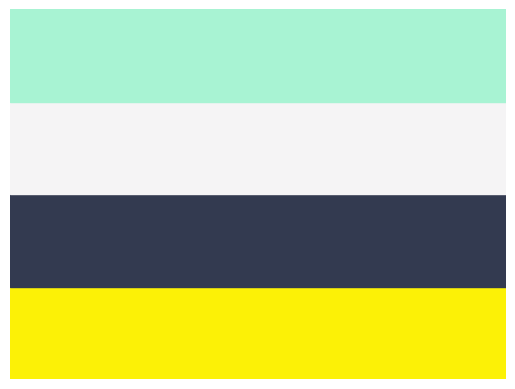

In [ ]:
import matplotlib.pyplot as plt

# # Define the RGB values for demo vid
colors = [(252/255,241/255,6/255),
          (51/255,58/255,80/255),
          (245/255,244/255,245/255),
          (168/255,243/255,211/255)]

# Define the RGB values for test vid
# colors = [(220/255,98/255,88/255),
#           (41/255,71/255,138/255),
#           (144/255,200/255,255/255),
#           (188/255,199/255,3/255)]

# Create a figure and axis
fig, ax = plt.subplots()

# Draw rectangles for each color
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color))

# Set axis limits and remove the axis
ax.set_xlim(0, 1)
ax.set_ylim(0, len(colors))
ax.axis('off')

plt.show()

# Yellow GK rgb(252,241,6)
# Dark blue rgb(51,58,80)

# white rgb(245,244,245)
# green GK rgb(168,243,211)


In [ ]:
# Load the YOLOv8 players detection model
model_players = YOLO("/content/drive/MyDrive/Req Data/best_players.pt")

# Load the YOLOv8 field keypoints detection model
model_keypoints = YOLO("/content/drive/MyDrive/Req Data/best_field.pt")

In [ ]:
##################
#      TEST      #
##################

# Open video file
cap = cv2.VideoCapture(video_path)

# Initialize frame counter
frame_nbr = 0

# Set keypoints average displacement tolerance level (in pixels) [set to -1 to always update homography matrix]
keypoints_displacement_mean_tol = 10

# Set confidence thresholds for players and field keypoints detections
player_model_conf_thresh = 0.60
keypoints_model_conf_thresh = 0.70

# Set variable to record the time when we processed last frame
prev_frame_time = 0
# Set variable to record the time at which we processed current frame
new_frame_time = 0

# Store the ball track history
ball_track_history = {'src':[],
                      'dst':[]
}

# Count consecutive frames with no ball detected
nbr_frames_no_ball = 0
# Threshold for number of frames with no ball to reset ball track (frames)
nbr_frames_no_ball_thresh = 30
# Distance threshold for ball tracking (pixels)
ball_track_dist_thresh = 100
# Maximum ball track length (detections)
max_track_length = 35

df = None

# Define the output video file path
output_ann_video_path = '/content/drive/MyDrive/Req Data/output_ann_video_demo.mp4'

# Define the codec and video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_ann_video = cv2.VideoWriter(output_ann_video_path, fourcc, 1, (1634, 770))

# Loop through the video frames
while (cap.isOpened() and frame_nbr<=50):
#while (cap.isOpened()):

    # Update frame counter
    print('Frame =',frame_nbr)
    frame_nbr += 1

    # Read a frame from the video
    success, frame = cap.read()

    # Reset tactical map image for each new frame
    tac_map_copy = tac_map.copy()

    # Reset ball tracks
    if nbr_frames_no_ball>nbr_frames_no_ball_thresh:
            ball_track_history['dst'] = []
            ball_track_history['src'] = []

    # Process the frame if it was successfuly read
    if success:

        #################### Part 1 ####################
        # Object Detection & Coordiante Transofrmation #
        ################################################

        # Run YOLOv8 players inference on the frame
        results_players = model_players(frame, conf=player_model_conf_thresh)
        # Run YOLOv8 field keypoints inference on the frame
        results_keypoints = model_keypoints(frame, conf=keypoints_model_conf_thresh)

        ## Extract detections information
        bboxes_p = results_players[0].boxes.xyxy.cpu().numpy()                          # Detected players, referees and ball (x,y,x,y) bounding boxes
        bboxes_p_c = results_players[0].boxes.xywh.cpu().numpy()                        # Detected players, referees and ball (x,y,w,h) bounding boxes
        labels_p = list(results_players[0].boxes.cls.cpu().numpy())                     # Detected players, referees and ball labels list
        confs_p = list(results_players[0].boxes.conf.cpu().numpy())                     # Detected players, referees and ball confidence level

        bboxes_k = results_keypoints[0].boxes.xyxy.cpu().numpy()                        # Detected field keypoints (x,y,x,y) bounding boxes
        bboxes_k_c = results_keypoints[0].boxes.xywh.cpu().numpy()                        # Detected field keypoints (x,y,w,h) bounding boxes
        labels_k = list(results_keypoints[0].boxes.cls.cpu().numpy())                   # Detected field keypoints labels list

        # Convert detected numerical labels to alphabetical labels
        detected_labels = [classes_names_dic[i] for i in labels_k]

        # Extract detected field keypoints coordiantes on the current frame
        detected_labels_src_pts = np.array([list(np.round(bboxes_k_c[i][:2]).astype(int)) for i in range(bboxes_k_c.shape[0])])

        # Get the detected field keypoints coordinates on the tactical map
        detected_labels_dst_pts = np.array([keypoints_map_pos[i] for i in detected_labels])


        ## Calculate Homography transformation matrix when more than 4 keypoints are detected
        if len(detected_labels) > 3:
            # Always calculate homography matrix on the first frame
            if frame_nbr > 1:
                # Determine common detected field keypoints between previous and current frames
                common_labels = set(detected_labels_prev) & set(detected_labels)
                # When at least 4 common keypoints are detected, determine if they are displaced on average beyond a certain tolerance level
                if len(common_labels) > 3:
                    common_label_idx_prev = [detected_labels_prev.index(i) for i in common_labels]   # Get labels indexes of common detected keypoints from previous frame
                    common_label_idx_curr = [detected_labels.index(i) for i in common_labels]        # Get labels indexes of common detected keypoints from current frame
                    coor_common_label_prev = detected_labels_src_pts_prev[common_label_idx_prev]     # Get labels coordiantes of common detected keypoints from previous frame
                    coor_common_label_curr = detected_labels_src_pts[common_label_idx_curr]          # Get labels coordiantes of common detected keypoints from current frame
                    coor_error = mean_squared_error(coor_common_label_prev, coor_common_label_curr)  # Calculate error between previous and current common keypoints coordinates
                    update_homography = coor_error > keypoints_displacement_mean_tol                 # Check if error surpassed the predefined tolerance level
                else:
                    update_homography = True
            else:
                update_homography = True

            if  update_homography:
                h, mask = cv2.findHomography(detected_labels_src_pts,                   # Calculate homography matrix
                                              detected_labels_dst_pts)

            detected_labels_prev = detected_labels.copy()                               # Save current detected keypoint labels for next frame
            detected_labels_src_pts_prev = detected_labels_src_pts.copy()               # Save current detected keypoint coordiantes for next frame

            bboxes_p_c_0 = bboxes_p_c[[i==0 for i in labels_p],:]                       # Get bounding boxes information (x,y,w,h) of detected players (label 0)
            bboxes_p_c_2 = bboxes_p_c[[i==2 for i in labels_p],:]                       # Get bounding boxes information (x,y,w,h) of detected ball(s) (label 2)

            # Get coordinates of detected players on frame (x_cencter, y_center+h/2)
            detected_ppos_src_pts = bboxes_p_c_0[:,:2]  + np.array([[0]*bboxes_p_c_0.shape[0], bboxes_p_c_0[:,3]/2]).transpose()
            # Get coordinates of the first detected ball (x_center, y_center)
            detected_ball_src_pos = bboxes_p_c_2[0,:2] if bboxes_p_c_2.shape[0]>0 else None

            # Transform players coordinates from frame plane to tactical map plance using the calculated Homography matrix
            pred_dst_pts = []                                                           # Initialize players tactical map coordiantes list
            for pt in detected_ppos_src_pts:                                            # Loop over players frame coordiantes
                pt = np.append(np.array(pt), np.array([1]), axis=0)                     # Covert to homogeneous coordiantes
                dest_point = np.matmul(h, np.transpose(pt))                              # Apply homography transofrmation
                dest_point = dest_point/dest_point[2]                                   # Revert to 2D-coordiantes
                pred_dst_pts.append(list(np.transpose(dest_point)[:2]))                 # Update players tactical map coordiantes list
            pred_dst_pts = np.array(pred_dst_pts)
            #print(pred_dst_pts[0], pred_dst_pts.shape)

            # Transform ball coordinates from frame plane to tactical map plane using the calculated Homography matrix
            if detected_ball_src_pos is not None:
                pt = np.append(np.array(detected_ball_src_pos), np.array([1]), axis=0)
                dest_point = np.matmul(h, np.transpose(pt))
                dest_point = dest_point/dest_point[2]
                detected_ball_dst_pos = np.transpose(dest_point)
                #print(frame_nbr, detected_ball_dst_pos)

                # Update track ball position history
                if len(ball_track_history['src'])>0 :
                    if np.linalg.norm(detected_ball_src_pos-ball_track_history['src'][-1])<ball_track_dist_thresh:
                        ball_track_history['src'].append((int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1])))
                        ball_track_history['dst'].append((int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1])))
                    else:
                        ball_track_history['src']=[(int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1]))]
                        ball_track_history['dst']=[(int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1]))]
                else:
                    ball_track_history['src'].append((int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1])))
                    ball_track_history['dst'].append((int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1])))
            # Remove oldest tracked ball postion if track exceedes threshold
            if len(ball_track_history) > max_track_length:
                    ball_track_history['src'].pop(0)
                    ball_track_history['dst'].pop(0)

        ######### Part 2 ##########
        # Players Team Prediction #
        ###########################

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)                                      # Convert frame to RGB
        obj_palette_list = []                                                                   # Initialize players color palette list
        palette_interval = (0,5)                                                                # Color interval to extract from dominant colors palette (1rd to 5th color)
        annotated_frame = frame                                                                 # Create annotated frame

        ## Loop over detected players (label 0) and extract dominant colors palette based on defined interval
        for i, j in enumerate(list(results_players[0].boxes.cls.cpu().numpy())):
            if int(j) == 0:
                bbox = results_players[0].boxes.xyxy.cpu().numpy()[i,:]                         # Get bbox info (x,y,x,y)
                obj_img = frame_rgb[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]       # Crop bbox out of the frame
                obj_img_w, obj_img_h = obj_img.shape[1], obj_img.shape[0]
                center_filter_x1 = np.max([(obj_img_w//2)-(obj_img_w//5), 1])
                center_filter_x2 = (obj_img_w//2)+(obj_img_w//5)
                center_filter_y1 = np.max([(obj_img_h//3)-(obj_img_h//5), 1])
                center_filter_y2 = (obj_img_h//3)+(obj_img_h//5)
                center_filter = obj_img[center_filter_y1:center_filter_y2,
                                        center_filter_x1:center_filter_x2]
                obj_pil_img = Image.fromarray(np.uint8(center_filter))                          # Convert to pillow image

                reduced = obj_pil_img.convert("P", palette=Image.Palette.WEB)                   # Convert to web palette (216 colors)
                palette = reduced.getpalette()                                                  # Get palette as [r,g,b,r,g,b,...]
                palette = [palette[3*n:3*n+3] for n in range(256)]                              # Group 3 by 3 = [[r,g,b],[r,g,b],...]
                color_count = [(n, palette[m]) for n,m in reduced.getcolors()]                  # Create list of palette colors with their frequency
                RGB_df = pd.DataFrame(color_count, columns = ['cnt', 'RGB']).sort_values(       # Create dataframe based on defined palette interval
                                      by = 'cnt', ascending = False).iloc[
                                          palette_interval[0]:palette_interval[1],:]
                palette = list(RGB_df.RGB)                                                      # Convert palette to list (for faster processing)
                annotated_frame = cv2.rectangle(annotated_frame,                                # Add center filter bbox annotations
                                                (int(bbox[0])+center_filter_x1,
                                                 int(bbox[1])+ center_filter_y1),
                                                (int(bbox[0])+center_filter_x2,
                                                 int(bbox[1])+center_filter_y2), (0,0,0), 2)

                # Update detected players color palette list
                obj_palette_list.append(palette)

        ## Calculate distances between each color from every detected player color palette and the predefined teams colors
        players_distance_features = []
        # Loop over detected players extracted color palettes
        for palette in obj_palette_list:
            palette_distance = []
            palette_lab = [skimage.color.rgb2lab([i/255 for i in color]) for color in palette]  # Convert colors to L*a*b* space
            # Loop over colors in palette
            for color in palette_lab:
                distance_list = []
                # Loop over predefined list of teams colors
                for c in color_list_lab:
                    #distance = np.linalg.norm([i/255 - j/255 for i,j in zip(color,c)])
                    distance = skimage.color.deltaE_cie76(color, c)                             # Calculate Euclidean distance in Lab color space
                    distance_list.append(distance)                                              # Update distance list for current color
                palette_distance.append(distance_list)                                          # Update distance list for current palette
            players_distance_features.append(palette_distance)                                  # Update distance features list

        ## Predict detected players teams based on distance features
        players_teams_list = []
        # Loop over players distance features
        for distance_feats in players_distance_features:
            vote_list=[]
            # Loop over distances for each color
            for dist_list in distance_feats:
                team_idx = dist_list.index(min(dist_list))//nbr_team_colors                     # Assign team index for current color based on min distance
                vote_list.append(team_idx)                                                      # Update vote voting list with current color team prediction
            players_teams_list.append(max(vote_list, key=vote_list.count))                      # Predict current player team by vote counting


        #########
        #   DF  #
        #########


        # players_teams_list = np.array(players_teams_list)
        # print(players_teams_list[0],pred_dst_pts[0])
        # print(players_teams_list.shape, pred_dst_pts.shape)
        pred_dst_pts_list = pred_dst_pts.tolist()
        detected_ball_dst_pos_temp = detected_ball_dst_pos[:-1].tolist()
        detected_ball_dst_pos_list = [detected_ball_dst_pos_temp]*len(players_teams_list)
        #print(pred_dst_pts_list,'\n',detected_ball_dst_pos,'\n',players_teams_list)
        #print(players_teams_list)
        data_bbd = {'Frame Number':frame_nbr, 'Player Coordinates': pred_dst_pts_list, 'Resp Team': players_teams_list, 'Ball Coordinates':detected_ball_dst_pos_list}

        # Create a DataFrame from the dictionary
        df_bbd = pd.DataFrame(data_bbd)
        df = pd.concat([df, df_bbd], ignore_index=True)


        # Display the DataFrame
        #print(df_bbd)


        #################### Part 3 #####################
        # Updated Frame & Tactical Map With Annotations #
        #################################################

        ball_color_bgr = (0,0,255)                                                                          # Color (GBR) for ball annotation on tactical map
        j=0                                                                                                 # Initializing counter of detected players
        palette_box_size = 10                                                                               # Set color box size in pixels (for display)


        # Loop over all detected object by players detection model
        for i in range(bboxes_p.shape[0]):
            conf = confs_p[i]                                                                               # Get confidence of current detected object
            if labels_p[i]==0:                                                                              # Display annotation for detected players (label 0)

                # Display extracted color palette for each detected player
                palette = obj_palette_list[j]                                                               # Get color palette of the detected player
                for k, c in enumerate(palette):
                    c_bgr = c[::-1]                                                                         # Convert color to BGR
                    annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,2])+3,                 # Add color palette annotation on frame
                                                            int(bboxes_p[i,1])+k*palette_box_size),
                                                            (int(bboxes_p[i,2])+palette_box_size,
                                                            int(bboxes_p[i,1])+(palette_box_size)*(k+1)),
                                                              c_bgr, -1)

                team_name = list(colors_dic.keys())[players_teams_list[j]]                                  # Get detected player team prediction
                color_rgb = colors_dic[team_name][0]                                                        # Get detected player team color
                color_bgr = color_rgb[::-1]                                                                 # Convert color to bgr

                annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,0]), int(bboxes_p[i,1])),  # Add bbox annotations with team colors
                                                (int(bboxes_p[i,2]), int(bboxes_p[i,3])), color_bgr, 1)

                cv2.putText(annotated_frame, team_name + f" {conf:.2f}",                                    # Add team name annotations
                             (int(bboxes_p[i,0]), int(bboxes_p[i,1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                               color_bgr, 2)

                # Add tactical map player postion color coded annotation if more than 3 field keypoints are detected
                if len(detected_labels_src_pts)>3:
                    tac_map_copy = cv2.circle(tac_map_copy, (int(pred_dst_pts[j][0]),int(pred_dst_pts[j][1])),
                                          radius=5, color=color_bgr, thickness=-1)

                j+=1                                                                                        # Update players counter
            else:                                                                                           # Display annotation for otehr detections (label 1, 2)
                annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,0]), int(bboxes_p[i,1])),  # Add white colored bbox annotations
                                                 (int(bboxes_p[i,2]), int(bboxes_p[i,3])), (255,255,255), 1)
                cv2.putText(annotated_frame, labels_dic[labels_p[i]] + f" {conf:.2f}",                      # Add white colored label text annotations
                            (int(bboxes_p[i,0]), int(bboxes_p[i,1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                              (255,255,255), 2)

                # Add tactical map ball postion annotation if detected
                if detected_ball_src_pos is not None:
                    tac_map_copy = cv2.circle(tac_map_copy, (int(detected_ball_dst_pos[0]),
                                                   int(detected_ball_dst_pos[1])), radius=5,
                                                   color=ball_color_bgr, thickness=3)
        for i in range(bboxes_k.shape[0]):
            annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_k[i,0]), int(bboxes_k[i,1])),  # Add bbox annotations with team colors
                                        (int(bboxes_k[i,2]), int(bboxes_k[i,3])), (0,0,0), 1)

        # Plot the ball tracks on tactical map
        if len(ball_track_history['src'])>0:
            points = np.hstack(ball_track_history['dst']).astype(np.int32).reshape((-1, 1, 2))
            tac_map_copy = cv2.polylines(tac_map_copy, [points], isClosed=False, color=(0, 0, 100), thickness=2)

        # Combine annotated frame and tactical map in one image with colored border separation
        border_color = [255,255,255]                                                                        # Set border color (BGR)
        annotated_frame=cv2.copyMakeBorder(annotated_frame, 40, 10, 10, 10,                                 # Add borders to annotated frame
                                            cv2.BORDER_CONSTANT, value=border_color)
        tac_map_copy = cv2.copyMakeBorder(tac_map_copy, 70, 50, 10, 10, cv2.BORDER_CONSTANT,                # Add borders to tactical map
                                           value=border_color)
        tac_map_copy = cv2.resize(tac_map_copy, (tac_map_copy.shape[1], annotated_frame.shape[0]))          # Resize tactical map
        final_img = cv2.hconcat((annotated_frame, tac_map_copy))                                            # Concatenate both images
        ## Add info annotation
        cv2.putText(final_img, "Tactical Map", (1370,60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)
        cv2.putText(final_img, "Press 'p' to pause & 'q' to quit", (820,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)

        new_frame_time = time.time()                                                                        # Get time after finished processing current frame
        fps = 1/(new_frame_time-prev_frame_time)                                                            # Calculate FPS as 1/(frame proceesing duration)
        prev_frame_time = new_frame_time                                                                    # Save current time to be used in next frame
        cv2.putText(final_img, "FPS: " + str(int(fps)), (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)

        # Display the final annotated frame
        # cv2.imshow("YOLOv8 Players and Field Keypoints Detection with Team Prediction and Tactical Map",
        #             final_img)
        print(final_img.shape)
        output_ann_video.write(final_img)

        # # Treat keyboard user inputs ("p" for pause/unpause & "q" for quit)
        # key = cv2.waitKey(1)
        # # Break the loop if 'q' is pressed
        # if key == ord("q"):
        #     break
        # if key == ord('p'):
        #     cv2.waitKey(-1) #wait until any key is pressed
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
output_ann_video.release()
cap.release()
cv2.destroyAllWindows()

Frame = 0

0: 384x640 18 players, 1 referee, 2775.3ms
Speed: 6.4ms preprocess, 2775.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 TLC, 1 TRC, 1 TR6MC, 1 TL6MC, 1 TR6ML, 1 TL6ML, 1 TR18MC, 1 TL18MC, 1 TR18ML, 1 TL18ML, 1 TRArc, 1 TLArc, 1 RMC, 1 LMC, 1 LML, 1 BR6MC, 1 BL6MC, 1 BL18MC, 1 BRArc, 1 BLArc, 1521.5ms
Speed: 3.4ms preprocess, 1521.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
(770, 1634, 3)
Frame = 1

0: 384x640 19 players, 2 referees, 1 ball, 1749.9ms
Speed: 2.6ms preprocess, 1749.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 TLC, 1 TRC, 1 TR6MC, 1 TR6ML, 1 TL6ML, 1 TR18MC, 1 TL18MC, 1 TR18ML, 1 TL18ML, 1 TRArc, 1 TLArc, 1 RMC, 1 LMC, 1 LML, 1 BR6MC, 1 BL6MC, 1 BL18MC, 1 BRArc, 1 BLArc, 880.9ms
Speed: 2.9ms preprocess, 880.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
(770, 1634, 3)
Frame = 2

0: 384x640 20 players, 2 referees, 1 ball, 1732.7ms
Speed: 4.1ms 

In [ ]:
print(df)
df.to_csv('/content/drive/MyDrive/Req Data/df_test_vid.csv', index=False)

      Frame Number                        Player Coordinates  Resp Team  \
0                1  [131.46752926011547, 356.34596853272944]          0   
1                1  [127.63509209601106, 297.44569113867254]          0   
2                1    [24.18393177127066, 327.1815590463966]          0   
3                1  [128.05405138668496, 163.61734586259882]          0   
4                1   [128.13418448297125, 61.80262556316589]          1   
...            ...                                       ...        ...   
7292           401   [105.43547290169991, 455.1808537268486]          0   
7293           401     [148.105093653128, 283.4526822313885]          1   
7294           401  [134.44315609514362, 482.43757430506304]          0   
7295           401  [140.11422178307959, 466.63488690193395]          0   
7296           401    [51.91071486217723, 304.5857350048348]          0   

                            Ball Coordinates  
0     [84.49156476604611, 351.7986141653759]  
1    

In [ ]:
#####################
#  BALL POSSESSION  #
#####################

import pandas as pd
from scipy.spatial import distance

# Assuming df is your DataFrame

# Function to calculate distance
def calc_distance(row):
    player_coords = row['Player Coordinates']
    ball_coords = row['Ball Coordinates']
    return distance.euclidean(player_coords, ball_coords)

# Apply the function to calculate distance for each row
df['Distance'] = df.apply(calc_distance, axis=1)

# Identify the closest player for each frame
closest_players = df.loc[df.groupby('Frame Number')['Distance'].idxmin()]
print(closest_players)

# Count the number of frames closest to the ball by each team
ball_possession_count = closest_players['Resp Team'].value_counts()

# Total number of frames where possession is identified
total_frames = closest_players['Frame Number'].nunique()

# Calculate possession rate
possession_rate = ball_possession_count / total_frames * 100

# Assuming Team A is represented by 1 and Team B by 0
possession_rate_A = possession_rate.get(1, 0)
possession_rate_B = possession_rate.get(0, 0)

print(f"Team A Ball Possession Rate: {possession_rate_A}%")
print(f"Team B Ball Possession Rate: {possession_rate_B}%")

      Frame Number                        Player Coordinates  Resp Team  \
18               1    [76.18634581009626, 358.9328584759613]          0   
37               2   [76.09696265429764, 358.85514350481805]          0   
38               3   [131.33443722686354, 356.8840795411538]          0   
56               4   [131.2771266663032, 357.33325988278983]          0   
90               5     [76.4602305263198, 358.2598632525344]          0   
...            ...                                       ...        ...   
7230           397  [137.29815373073555, 462.02532123006137]          0   
7247           398    [137.89151793330987, 460.849576253772]          0   
7268           399  [138.55909589692124, 463.73807675096197]          0   
7283           400  [138.70870326416056, 477.34682540596896]          0   
7294           401  [134.44315609514362, 482.43757430506304]          0   

                             Ball Coordinates   Distance  
18     [84.49156476604611, 351.798614165

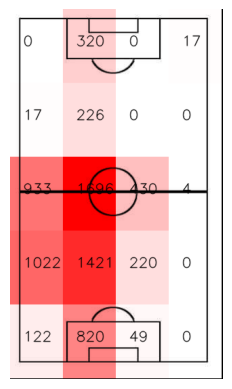

True

In [ ]:
#############
#  HEATMAP  #
#############

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the image
tac_map = cv2.imread('/content/drive/MyDrive/Req Data/tactical map.jpg')

# Load the DataFrame
# Assuming you already have the DataFrame named df

# Get the dimensions of the image
height, width, _ = tac_map.shape

# Calculate the dimensions of each region
region_height = height // 5  # Divide height into 5 regions
region_width = width // 4    # Divide width into 4 regions

# Initialize a dictionary to store the count of points in each region
region_counts = {i: 0 for i in range(20)}

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    # Extract player coordinates
    player_coords = row['Player Coordinates']

    # Determine which region the point belongs to
    x, y = player_coords
    region_x = min(x // region_width, 3)
    region_y = min(y // region_height, 4)
    region_index = region_y * 4 + region_x

    # Increment the count for the corresponding region
    #print(region_index, x, y)
    region_counts[np.abs(region_index)] += 1

# region_counts = {0:0,
#                  1:10,
#                  2:20,
#                  3:30,
#                  4:50,
#                  5:10,
#                  6:90,
#                  7:0,
#                  8:25,
#                  9:110,
#                  10:0,
#                  11:10,
#                  12:20,
#                  13:30,
#                  14:50,
#                  15:10,
#                  16:90,
#                  17:50,
#                  18:250,
#                  19:100}
# print(region_counts)

# Find the maximum and minimum counts for normalization
max_count = max(region_counts.values())
min_count = min(region_counts.values())

# Create a gradient from pure red to white
gradient = np.linspace(0, 255, 256)
colors = np.zeros((256, 3))
colors[:, 2] = 255  # Set blue channel to 255
colors[:, 1] = gradient[::-1]  # Set green channel to gradient
colors[:, 0] = gradient[::-1]  # Set red channel to gradient

# Create a transparent color map image
color_map = np.zeros((height, width, 3), dtype=np.uint8)

# Iterate through each region and fill it with the corresponding color
for i, count in region_counts.items():
    region_color = colors[int(255 * (count - min_count) / (max_count - min_count))]
    region_x_start = (i % 4) * region_width
    region_x_end = region_x_start + region_width
    region_y_start = (i // 4) * region_height
    region_y_end = region_y_start + region_height
    color_map[region_y_start:region_y_end, region_x_start:region_x_end] = region_color
    #To display the numbers
    cv2.putText(tac_map, str(count), ((region_x_start + region_width // 2)-20, region_y_start + region_height // 2),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)

# Blend the color map with the tac_map using multiply blending mode
blended_image = cv2.multiply(tac_map.astype(float) / 255, color_map.astype(float) / 255) * 255

# Convert the blended image back to uint8
blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

# Display the blended image
blended_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)
plt.imshow(blended_image_rgb)
plt.axis('off')
plt.show()

cv2.imwrite('/content/drive/MyDrive/Req Data/hm_test_vid.jpg', blended_image)

In [ ]:
###############
#     BALL    #
###############


import cv2
import matplotlib.pyplot as plt

# Define the output video file path
output_video_path = '/content/drive/MyDrive/Req Data/output_video_test.mp4'

# Read the tactical map image
tac_map = cv2.imread('/content/drive/MyDrive/Req Data/tactical map.jpg')

# Define colors for different teams
team_colors = {0: (0, 0, 255), 1: (255, 0, 0)}  # Team A: Blue, Team B: Red

# Define the codec and video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, fourcc, 1, (tac_map.shape[1], tac_map.shape[0]))

# Iterate over each frame in the DataFrame
for frame_number in df['Frame Number'].unique():
    # Filter the DataFrame for the current frame number
    frame_data = df[df['Frame Number'] == frame_number]

    # Make a copy of the tactical map for each frame
    annotated_map = tac_map.copy()

    # Loop through player coordinates for the current frame and draw circles on the image
    for index, row in frame_data.iterrows():
        # Draw player coordinates
        player_coord = row['Player Coordinates']
        x, y = int(player_coord[0]), int(player_coord[1])
        team = row['Resp Team']
        cv2.circle(annotated_map, (x, y), 5, team_colors[team], -1)  # Draw circle with respective team color

        # Draw ball coordinates
        ball_coord = row['Ball Coordinates']
        x, y = int(ball_coord[0]), int(ball_coord[1])
        cv2.circle(annotated_map, (x, y), 5, (0, 255, 0), -1)  # Draw green circle for the ball

    # Write the frame number on the bottom of the frame
    cv2.putText(annotated_map, f"Frame: {frame_number}", (50, tac_map.shape[0] - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    # Write the annotated map with player coordinates, ball coordinates, and frame number to the video for 1 second
    #for _ in range(1):  # Repeat each frame 25 times to keep it for 1 second
    output_video.write(annotated_map)

# Release the video writer
output_video.release()
print("Video saved successfully.")


Video saved successfully.


In [ ]:
import sqlite3
df_same = pd.read_csv('/content/drive/MyDrive/Req Data/df_test_vid.csv')
conn = sqlite3.connect('myDB1.db')
df_same.to_sql('table_name', conn, if_exists='replace', index=False)
conn.close()

In [ ]:
####################
##  SQL DATABASE  ##
####################

from scipy.spatial import distance
from ast import literal_eval

conn = sqlite3.connect('myDB1.db')  # Replace 'myDB1.db' with your database file path
query = "SELECT * FROM table_name"
df_same = pd.read_sql_query(query, conn)
conn.close()

# Function to calculate distance
def calc_distance(row):
    player_coords = row['Player Coordinates']
    ball_coords = row['Ball Coordinates']
    return distance.euclidean(literal_eval(player_coords), literal_eval(ball_coords))

# Apply the function to calculate distance for each row
df_same['Distance'] = df_same.apply(calc_distance, axis=1)

# Identify the closest player for each frame
closest_players = df_same.loc[df_same.groupby('Frame Number')['Distance'].idxmin()]
print(closest_players)

# Count the number of frames closest to the ball by each team
ball_possession_count = closest_players['Resp Team'].value_counts()

# Total number of frames where possession is identified
total_frames = closest_players['Frame Number'].nunique()

# Calculate possession rate
possession_rate = ball_possession_count / total_frames * 100

# Assuming Team A is represented by 1 and Team B by 0
possession_rate_A = possession_rate.get(1, 0)
possession_rate_B = possession_rate.get(0, 0)

print(f"Team A Ball Possession Rate: {possession_rate_A}%")
print(f"Team B Ball Possession Rate: {possession_rate_B}%")

      Frame Number                        Player Coordinates  Resp Team  \
18               1    [76.18634581009626, 358.9328584759613]          0   
37               2   [76.09696265429764, 358.85514350481805]          0   
38               3   [131.33443722686354, 356.8840795411538]          0   
56               4   [131.2771266663032, 357.33325988278983]          0   
90               5     [76.4602305263198, 358.2598632525344]          0   
...            ...                                       ...        ...   
7230           397  [137.29815373073555, 462.02532123006137]          0   
7247           398    [137.89151793330987, 460.849576253772]          0   
7268           399  [138.55909589692124, 463.73807675096197]          0   
7283           400  [138.70870326416056, 477.34682540596896]          0   
7294           401  [134.44315609514362, 482.43757430506304]          0   

                             Ball Coordinates   Distance  
18     [84.49156476604611, 351.798614165